In [271]:
# imports
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

In [10]:
# define 5 documents
docs = ['Well done!',
        'Good work work',
        'Great effort',
        'Nice work',
        'Excellent!']

In [11]:
t = Tokenizer()

In [12]:
t.fit_on_texts(docs)

In [13]:
# 'work' appears 3 times
print(t.word_counts)

OrderedDict([('well', 1), ('done', 1), ('good', 1), ('work', 3), ('great', 1), ('effort', 1), ('nice', 1), ('excellent', 1)])


In [14]:
print(t.word_index)

{'work': 1, 'well': 2, 'done': 3, 'good': 4, 'great': 5, 'effort': 6, 'nice': 7, 'excellent': 8}


In [15]:
# 'work' appears in 2 documents
print(t.word_docs)

defaultdict(<class 'int'>, {'well': 1, 'done': 1, 'good': 1, 'work': 2, 'great': 1, 'effort': 1, 'nice': 1, 'excellent': 1})


In [342]:
new_doc = ['Excellent work done good great, Bob!']

In [343]:
# Whether or not each word is present in the document. mode = 'binary' is the default.
encoded_doc = t.texts_to_matrix(new_doc, mode = 'binary')
print(encoded_doc[0])

[0. 1. 0. 1. 1. 1. 0. 0. 1.]


In [34]:
# matches up with t.word_index
# ignores "Bob"
encoded_seq = t.texts_to_sequences(new_doc)
print(encoded_seq[0])

[8, 1, 3, 4, 5]


In [325]:
# adds zeros to the front of the sequence
print(pad_sequences([encoded_seq[0]], maxlen=10).shape)
print(pad_sequences([encoded_seq[0]], maxlen=10)[0].shape)

(1, 10)
(10,)


In [344]:
to_categorical([5], num_classes=10)

array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]], dtype=float32)

# Features/weights of all images

- transfer learning: strip off last layer of CNN - probably a fully connected layer with softmax activation, for classification - take the weights (4096 x 1) and feed into an RNN (specifically LSTM)
- greedy search vs beam search for image caption
- think of a tree structure 
- greedy search: given a word, choose the most likely next word; then, given the first two words, choose the most likely third word, etc.
- greedy search may not result in globally optimal outcome
- beam search: given a word, limit to top N most likely next words....
- other extreme: form every possible caption and choose the best
- model architecture of CNN: VGG (Visual Geometry Group) model, which is pretrained on the ImageNet dataset, has 16 layers
- reshape each of 8,000 color images

![caption_tree.png](caption_tree.png)

In [272]:
def extract_features(directory):
    """Modify VGG and pass all images through modified VGG; collect results in a dictionary"""
    # load the CNN model; need to import VGG
    model = VGG16()
    # pop off the last layer of this model
    model.layers.pop()
    print(model.summary())
    # output is the new last layer of the model; is this step necessary?
    # need to import Model
    model = Model(inputs = model.inputs, outputs = model.layers[-1].output)
    # view architecture / parameters
    print(model.summary())
    # pass all 8K images through the model and collect weights in a dictionary
    features = {}
    # need to import listdir
    for name in listdir(directory):
        filename = directory + '/' + name
        # load and reshape image
        # shouldn't target_size = (3,224,224)?
        image = load_img(filename, target_size = (224,224))
        # convert the image pixels to a (3 dimensional?) numpy array, then to a 4 dimensional array
        image = img_to_array(image)
        image = image.reshape((1,image.shape[0],image.shape[1],image.shape[2]))
        # preprocess image in a black box before passing into model
        image = preprocess_input(image)
        feature = model.predict(image, verbose = 0)
        # image_id - all but .jpg - will be a key in features dictionary
        image_id = name.split('.')[0]
        features[image_id] = feature
        print('>%s' % name)
    return features

In [311]:
# imports
from os import listdir
# will dump the features dictionary into a .pkl file
from pickle import dump, load
from keras.applications.vgg16 import VGG16, preprocess_input
# from keras.applications.vgg19 import VGG19
from keras.preprocessing.image import load_img, img_to_array
from keras.models import Model, load_model # used after copying model from EC2 instance

In [274]:
# checking the functionality of listdir
listdir('Flicker8k_Dataset/')[:5]

['2387197355_237f6f41ee.jpg',
 '2609847254_0ec40c1cce.jpg',
 '2046222127_a6f300e202.jpg',
 '2853743795_e90ebc669d.jpg',
 '2696951725_e0ae54f6da.jpg']

In [ ]:
directory = 'Flicker8k_Dataset/'

features = extract_features(directory)

In [ ]:
print('Extracted features for %d images' % len(features))

dump(features, open('features.pkl','wb')) # why 'wb' and not just 'w'?

# Images with multiple descriptions (human captions)

In [275]:
def load_doc(filename):
    """Open and read text file containing human captions - load into memory"""
    # open the file in read mode
    file = open(filename, 'r')
    # read all the human captions
    doc = file.read()
    # close the context manager
    file.close()
    return doc

In [276]:
filename_captions = 'Flickr8k_text/Flickr8k.token.txt'

doc = load_doc(filename_captions)

In [277]:
def load_descriptions(doc):
    """Dictionary of photo identifier (aka image_id) to list of 5 textual descriptions"""
    descriptions = {}
    # iterate through lines of doc
    for line in doc.split('\n'):
        tokens = line.split() # tokens is a list, split by whitespace
        if len(tokens) < 2:
            continue # move on to next line; continue vs pass?
        image_id, image_desc = tokens[0], tokens[1:]
        image_id = image_id.split('.')[0] # again, drop the .jpg
        # re-join the description after previously splitting
        image_desc = ' '.join(image_desc)
        if image_id not in descriptions.keys():
            descriptions[image_id] = []
        descriptions[image_id].append(image_desc) # .append for lists, .update for sets
    return descriptions

In [278]:
descriptions = load_descriptions(doc)

print(len(descriptions))

# this means there are 92 images not included in any of train, dev, and test sets

8092


## Clean the descriptions and reduce the size of the vocab

- convert all words to lowercase
- remove all punctuation; what's the easiest way to do this?
- remove words with fewer than 2 characters, e.g. "a"
- remove words containing at least one number

In [279]:
def clean_descriptions(descriptions):
    """Clean textual descriptions through a series of list comprehensions"""
    # make a translation table to filter out punctuation
    table = str.maketrans('', '', string.punctuation) # why can't it be ", " ??!!
    for key, desc_list in descriptions.items():
        # for desc in desc_list:
        for i in range(len(desc_list)):
            desc = desc_list[i]
            # tokenize the description
            desc = desc.split()
            # convert to lowercase via list comprehension
            desc = [word.lower() for word in desc]
            # probably can remove punctuation before converting to lowercase
            desc = [word.translate(table) for word in desc]
            desc = [word for word in desc if len(word) > 1]
            desc = [word for word in desc if word.isalpha()]
            # overwrite desc_list[i]
            desc_list[i] = ' '.join(desc)

In [280]:
import string

In [281]:
clean_descriptions(descriptions)

In [282]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [283]:
def to_vocabulary(descriptions):
    """Determine the size of the vocabulary: the number of unique words"""
    vocab = set()
    for key, desc_list in descriptions.items():
        for desc in desc_list:
            vocab.update(desc.split())
    return vocab

#     vocab = []
#     for key, desc_list in descriptions.items():
#         for desc in desc_list:
#             vocab.append(word for word in desc.split())
#     return set(vocab)

In [284]:
vocabulary = to_vocabulary(descriptions)

print('Size of vocabulary: %d' % len(vocabulary))

Size of vocabulary: 8763


In [285]:
def save_descriptions(descriptions, filename):
    """One line per description, not one line per image!"""
    lines = []
    for key, desc_list in descriptions.items():
        for desc in desc_list:
            lines.append(key + ' ' + desc)
    print(len(lines))
    data = '\n'.join(lines)
    file = open(filename, 'w') # why not "wb"?  "wb" only for .pkl
    file.write(data)
    file.close()

In [286]:
save_descriptions(descriptions, 'descriptions.txt')

40460


Note that $40460 = 8092\times 5$.

# Just the training images and descriptions

In [287]:
def load_set(filename):
    """Obtain list of image_id's for training images for filtering purposes"""
    doc = load_doc(filename)
    dataset = []
    for line in doc.split('\n'):
        if len(line) < 1:
            continue # will there be any line with zero characters ?!
        identifier = line.split('.')[0]
        dataset.append(identifier)
    return set(dataset) # why are we allowed to de-duplicate only at the very end?

In [288]:
def load_clean_descriptions(filename, dataset):
    """Load RELEVANT clean descriptions into memory, wrapped in startseq, endseq"""
    descriptions = {}
    doc = load_doc(filename)
    for line in doc.split('\n'):
        tokens = line.split()
        image_id, image_desc = tokens[0], tokens[1:] # done this before
        if image_id in dataset:
            if image_id not in descriptions.keys():
                descriptions[image_id] = []
            # wrap description in startseq, endseq
            image_desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
            descriptions[image_id].append(image_desc)
    return descriptions

In [289]:
def load_photo_features(filename, dataset):
    """Load FEATURES of relevant photos, as a dictionary"""
    all_features = load(open(filename, 'rb'))
    # filter based on image_id's with a dictionary comprehension
    features = {image_id: all_features[image_id] for image_id in dataset}
    return features

In [290]:
filename_training = 'Flickr8k_text/Flickr_8k.trainImages.txt'
train = load_set(filename_training)
print('Number of training images: %d' % len(train))

Number of training images: 6000


In [291]:
train_descriptions = load_clean_descriptions('descriptions.txt', train)
print(len(train_descriptions))

6000


In [ ]:
train_features = load_photo_features('features.pkl', train)
print(len(train_features))

In [292]:
def to_lines(descriptions):
    """All descriptions, of training images, in a list - prior to encoding"""
    all_desc = []
    for key, desc_list in descriptions.items():
        for desc in desc_list:
            all_desc.append(desc) # keys not included in all_desc
    return all_desc

In [293]:
def create_tokenizer(descriptions):
    """Fit Keras tokenizer on training descriptions"""
    all_desc = to_lines(descriptions)
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(all_desc)
    return tokenizer # return fitted tokenizer

In [294]:
tokenizer = create_tokenizer(train_descriptions)
training_vocab_size = len(tokenizer.word_index) + 1
# add 1 due to zero indexing
# tokenizer.word_index is a dictionary with keys being the (unique) words in the training vocabulary
# training vocab contains the words "startseq", "endseq"
print('Size of vocabulary - training images: %d' % training_vocab_size)

Size of vocabulary - training images: 7579


In [295]:
import numpy as np

In [296]:
def max_length(descriptions):
    """Return maximum length across all training descriptions"""
    all_desc = to_lines(descriptions)
    return max(len(desc.split()) for desc in all_desc)

In [297]:
max_length = max_length(train_descriptions)
print('Length of longest caption among training images: %d' % max_length)

Length of longest caption among training images: 34


In [298]:
def create_sequences(tokenizer,max_length,descriptions,photos): # more like create_arrays
    """Input - output pairs for each image"""
    X1, X2, y = [], [], []
    for key, desc_list in descriptions.items():
        for desc in desc_list:
            # encode each description; recall: each description begins with "startseq" and ends with "endseq"
            seq = tokenizer.texts_to_sequences([desc])[0] # already fitted tokenizer on training descriptions
            # convert seq into several X2, y pairs
            for i in range(1,len(seq)):
                in_seq, out_seq = seq[:i], seq[i]
                # add zeros to the front of in_seq so that len(in_seq) = max_length
                in_seq = pad_sequences([in_seq], maxlen = max_length)[0]
                # encode (one-hot-encode) out_seq
                out_seq = to_categorical([out_seq], num_classes = training_vocab_size)[0]
                X1.append(photos[key][0]) # why not just photos[key] ???
                X2.append(in_seq)
                y.append(out_seq)
    return np.array(X1), np.array(X2), np.array(y) # return numpy arrays for model training

In [ ]:
X1train, X2train, ytrain = create_sequences(tokenizer, max_length, train_descriptions, train_features)

In [ ]:
print(X1train.shape)
print(X2train.shape)
print(ytrain.shape)

# Model structure and training

In [299]:
def define_model(max_length, training_vocab_size):
    """Model which feeds photo features into an LSTM layer/cell and generates captions one word at a time"""
    input_1 = Input(shape = (4096,))
    f1 = Dropout(0.5)(input_1) # for regularization
    # fully connected layer with 256 nodes, 256 = 2 ** 8, 4096 = 2 ** 12
    f2 = Dense(256, activation = 'relu')(f1) # input_shape = , "leaky relu"
    
    input_2 = Input(shape = (max_length,))
    # recall that after padding, len(in_seq) = max_length
    # 5 human captions per image
    s1 = Embedding(input_dim = training_vocab_size, output_dim = 256, mask_zero = True)(input_2)
    # embed each word as a vector with 256 components
    s2 = Dropout(0.5)(s1)
    s3 = LSTM(256)(s2)
    
    decoder1 = add([f2,s3]) # f2 + s3
    decoder2 = Dense(256, activation = 'relu')(decoder1)
    outputs = Dense(training_vocab_size, activation = 'softmax')(decoder2)

    model = Model(inputs = [input_1, input_2], outputs = outputs)
    model.compile(loss = 'categorical_crossentropy', optimizer = 'adam') # model.fit, model.predict
    # categorical_crossentropy vs BLEU score
    # can't directly optimize for BLEU score
    
    print(model.summary())
    # plot_model(model, to_file = 'model.png', show_shapes = True)
    
    return model

- 6,000 training images - 30,000 training captions
- ~7,500 unique words in training captions - this is training_vocab_size
- after tokenizing, think of tokenizer.word_index dictionary
- values in this dictionary range from 1 to training_vocab_size
- from the documentation: If mask_zero is set to True (ignore zeros added during padding), input_dim should equal size of vocabulary + 1.

In [300]:
# imports
from keras.utils.vis_utils import plot_model
from keras.layers import Dense, Embedding, Input, LSTM, Dropout
from keras.layers.merge import add
from keras.callbacks import ModelCheckpoint

In [301]:
model = define_model(max_length, training_vocab_size)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_30 (InputLayer)           (None, 34)           0                                            
__________________________________________________________________________________________________
input_29 (InputLayer)           (None, 4096)         0                                            
__________________________________________________________________________________________________
embedding_14 (Embedding)        (None, 34, 256)      1940224     input_30[0][0]                   
__________________________________________________________________________________________________
dropout_27 (Dropout)            (None, 4096)         0           input_29[0][0]                   
__________________________________________________________________________________________________
dropout_28

- for embedding layer, $1940224 = 256\times 7579$
- $1048832 = (256\times 4096) + 256$
- for LSTM layer/cell, $525312 = 4(256^2 + (256\times 256) + 256)$
- $65792 = (256\times 256) + 256$
- $1947803 = (256\times 7579) + 7579$

![Plot-of-the-Caption-Generation-Deep-Learning-Model.png](Plot-of-the-Caption-Generation-Deep-Learning-Model.png)

In [302]:
# check validation loss after each epoch and save models which improve val_loss
filepath = 'model-ep{epoch:02d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5' # .hdf5
checkpoint = ModelCheckpoint(filepath, monitor = 'val_loss', verbose = 1, save_best_only = True, mode = 'min')

In [303]:
# dev images, i.e. validation images
filename_dev = 'Flickr8k_text/Flickr_8k.devImages.txt'
dev = load_set(filename_dev)
print('Number of images in dev dataset: %d' % len(dev))

Number of images in dev dataset: 1000


In [304]:
# include only descriptions pertaining to dev images
dev_descriptions = load_clean_descriptions('descriptions.txt', dev)
print(len(dev_descriptions))

1000


In [ ]:
# include only features pertaining to dev images
dev_features = load_photo_features('features.pkl', dev)
print(len(dev_features))

In [ ]:
# same max_length = 34, same tokenizer trained on training captions
X1dev, X2dev, ydev = create_sequences(tokenizer, max_length, dev_descriptions, dev_features)

In [ ]:
print(X1dev.shape)
print(X2dev.shape)
print(ydev.shape)

In [ ]:
# finally, let's fit the captioning model which was defined by define_model
# why 20 epochs? verbose = 2 more or less verbose than verbose = 1?
model.fit([X1train,X2train], ytrain, epochs=20, verbose=2, callbacks=[checkpoint], validation_data=([X1dev,X2dev], ydev))

# Model evaluation by BLEU scores

So far, we have used the training images to fit the captioning model, and the development images to determine val_loss.  Now we will use the *test* images for the first time, to evaluate the trained model.

In [306]:
def word_from_id(integer, tokenizer):
    """Convert integer (value) to corresponding vocabulary word (key) using tokenizer.word_index dictionary"""
    for word, index in tokenizer.word_index.items():
        if index == integer:            
            return word
    return None

In [326]:
def generate_caption(model, photo, tokenizer, max_length):
    """Given a photo feature vector, generate a caption, word by word, using the model just trained"""
    # caption begins with "startseq"
    in_text = 'startseq'
    # iterate over maximum potential length of caption
    for i in range(max_length):
        # encode in_text using tokenizer.word_index
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad this sequence so that its length is max_length = 34
        sequence = pad_sequences([sequence], maxlen = max_length)
        # predict next word in the sequence; y_vec is vector of probabilities with 7579 components
        y_vec = model.predict([photo,sequence], verbose = 0)
        # pick out the position of the word with greatest probability
        y_int = np.argmax(y_vec)
        # convert this position into English word by means of the function we just wrote
        word = word_from_id(y_int, tokenizer)
        if word is None:
            break
        # recursion: append word as input for generating the next word
        in_text += ' ' + word
        if word == 'endseq':
            break
    return in_text    

In [327]:
def evaluate_model(model, photos, descriptions, tokenizer, max_length):
    """Compare the generated caption with the 5 human descriptions across the whole test set"""
    actual, generated = [], []
    for key, desc_list in descriptions.items():
        yhat = generate_caption(model, photos[key], tokenizer, max_length)
        # each desc begins with "startseq" and ends with "endseq"
        # split_desc is a list of 5 sublists
        split_desc = [desc.split() for desc in desc_list]
        # actual is a list of lists of lists
        actual.append(split_desc)
        # generated is a list of lists
        generated.append(yhat.split())
    print(len(actual))
    print(len(generated))
    # compute BLEU scores
    print('BLEU-1: %f' % corpus_bleu(actual, generated, weights = (1.0,0,0,0)))
    print('BLEU-2: %f' % corpus_bleu(actual, generated, weights = (0.5,0.5,0,0)))
    print('BLEU-3: %f' % corpus_bleu(actual, generated, weights = (0.33,0.33,0.33,0)))
    print('BLEU-4: %f' % corpus_bleu(actual, generated, weights = (0.25,0.25,0.25,0.25)))

In [313]:
%%bash

pip install nltk

  Running setup.py bdist_wheel for nltk: started
  Running setup.py bdist_wheel for nltk: finished with status 'done'
  Stored in directory: /Users/kadakia/Library/Caches/pip/wheels/d1/ab/40/3bceea46922767e42986aef7606a600538ca80de6062dc266c
Successfully built nltk


In [314]:
from nltk.translate.bleu_score import corpus_bleu

In [317]:
# test images, previously unused
# shouldn't there be 1,092 test images?
filename_test = 'Flickr8k_text/Flickr_8k.testImages.txt'
test = load_set(filename_test)
print('Number of images in test dataset: %d' % len(test))

Number of images in test dataset: 1000


In [318]:
# include only descriptions pertaining to test images
test_descriptions = load_clean_descriptions('descriptions.txt', test)
print(len(test_descriptions))

1000


In [319]:
# include only features pertaining to test images
test_features = load_photo_features('features.pkl', test)
print(len(test_features))

1000


In [320]:
# load the model which was trained on an AWS EC2 instance
filename_model = 'model-ep3-loss3.664-val_loss3.839.h5'
model = load_model(filename_model)

In [328]:
evaluate_model(model, test_features, test_descriptions, tokenizer, max_length)

1000
1000
BLEU-1: 0.340888
BLEU-2: 0.175420
BLEU-3: 0.099687
BLEU-4: 0.051633


BLEU scores range from 0 (worst) to 1 (best).  **SHOULD GO BACK AND RETRAIN THE MODEL FOR MORE THAN 3 EPOCHS!!**

# Generate captions for entirely new images

In [329]:
dump(tokenizer, open('tokenizer.pkl', 'wb'))

In [332]:
def extract_features_2(filename):
    """Extract features for just one photo, unlike extract_features"""
    # instantiate Visual Geometry Group's CNN model
    model = VGG16()
    model.layers.pop()
    model = Model(inputs = model.inputs, outputs = model.layers[-1].output) # not strictly necessary
    
    # reshape image before passing through pretrained VGG model
    image = load_img(filename, target_size=(224,224))
    image = img_to_array(image)
    print(image.shape)
    image = image.reshape((1,image.shape[0],image.shape[1],image.shape[2]))
    print(image.shape)
    image = preprocess_input(image)
    
    features_2 = model.predict(image, verbose = 0) # the prediction is a vector with 4096 components
    return features_2

In [333]:
photo = extract_features_2('example.jpg')

(224, 224, 3)
(1, 224, 224, 3)


In [339]:
caption = generate_caption(model, photo, tokenizer, max_length)
caption = caption.split()
caption = ' '.join(caption[1:-1])
print(caption)

black dog is running through the water


![example.jpg](example.jpg)

In [345]:
import matplotlib.pyplot as plt

In [346]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

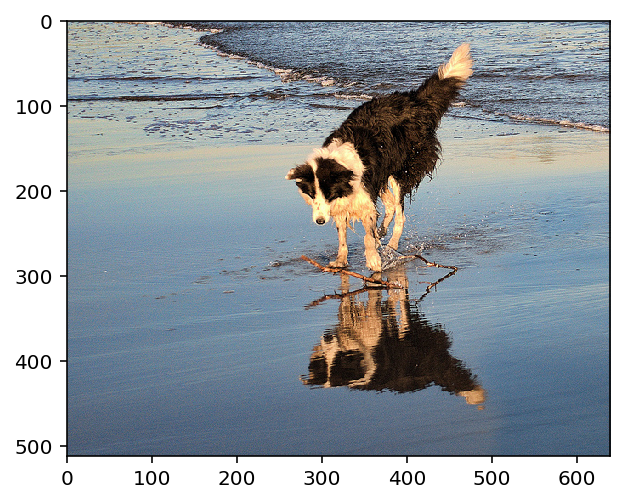

In [349]:
dog = plt.imread('example.jpg')
plt.imshow(dog);

# Binary search trees for practice with Classes

In [222]:
class Node:
    def __init__(self, value):
        self.val = value
        self.left = None
        self.right = None
        
    def trav(self):
        if self.left is not None:
            self.left.trav()
        print(self.val)
        if self.right is not None:
            self.right.trav()

In [202]:
node_8 = Node(8)
node_3 = Node(3)
node_10 = Node(10)

In [203]:
node_8.left = node_3
node_8.right = node_10

In [204]:
node_1 = Node(1)
node_6 = Node(6)

In [205]:
node_3.left = node_1
node_3.right = node_6

In [206]:
node_4 = Node(4)
node_7 = Node(7)

In [207]:
node_6.left = node_4
node_6.right = node_7

In [208]:
node_14 = Node(14)
node_13 = Node(13)

In [209]:
node_10.right = node_14
node_14.left = node_13

In [224]:
# NOT QUITE CORRECT FOR IN ORDER TRAVERSAL!
node_8.trav()

1
4
7
8
10
13
